In [1]:
!pwd
import sys
sys.executable

/c/Users/shingo/jupyter_notebook/tfgpu_py36_work/02_keras_py/experiment


'C:\\Users\\shingo\\Anaconda3\\envs\\tfgpu113\\python.exe'

# CIFAR10の画像で多クラス分類モデル試す
## <font color="Red">画像（x）,ラベル（y）データそのまま取得できる場合で分類モデル作成<font>

#### 自宅PC:tfgpu_py36_v3環境
- C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\experiment 


## モジュールimport

In [1]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util#, gradcam_xlsx_onesheet_label_prob, orgimg_xlsx_onesheet
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21, optuna_util

import pathlib
#current_dir = pathlib.Path("__file__").resolve().parent
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

sys.path.append(r'C:\Users\shingo\Git\mixup-generator')
from mixup_generator import MixupGenerator
from random_eraser import get_random_eraser

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

%reload_ext autoreload
%autoreload 2

C:\Users\shingo\Anaconda3\envs\tfgpu113\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


optuna_train_base.py: loaded as module file
optuna_train.py: loaded as module file
optuna_util.py: loaded as module file


## 画像をtrain/test set に分ける

In [2]:
import keras
from keras.datasets import cifar10

# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')
print(y_test[0], 'label -> ex: 3 ')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(y_test[0])


x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
50000 train samples
10000 test samples
[3] label -> ex: 3 
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]


## パラメータ設定

In [3]:
import keras
import os, sys, glob, time

# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py'
os.makedirs(output_dir, exist_ok=True)

# 入力層のサイズ
#img_rows, img_cols, channels=331, 331, 3
img_rows, img_cols, channels=32, 32, 3

# 分類クラス
class_name = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
classes = class_name
nb_classes = len(classes)
activation='softmax'

# GradCamで切り出す層名
layer_name = 'block5_conv3'#'block4_conv3'

# ハイパーパラメータ
num_epoch=5#2#10
batch_size=100
val_batch_size=100

# optimizer のパラメータ
choice_optim='sgd'
lr=0.01#0.1 * batch_size / 128
#decay=1e-3
momentum=0.9

# fine-tuningモデル
choice_model='OctConv_WideResNet'#'VGG16'
trainable=15

# 全結合層
FCnum=1

# 学習打ち切りオプション
early_stopping=10

plateau_pati=5
plateau_factor=0.5 # コールバックが起動したら学習率0.9倍
plateau_monitor='val_loss'

# https://qiita.com/ak11/items/67118e11b756b0ee83a5
base_lr = lr #0.1 * batch_size / 128  # adamとかなら1e-3くらい。SGDなら例えば 0.1 * batch_size / 128 とかくらい。nadamなら0.002*10 ?
lr_decay_rate = 1/2#1 / 3
lr_steps = 2#4

### 訓練画像水増しオプション
# ImageDataGenerator
rescale=1.0/255.0
vertical_flip=True
zoom_range=0.2
rotation_range=20
channel_shift_range=5.
brightness_range=[0.3, 1.0]
# custom param
#mix_up_alpha=0.2# mixup alpha
#random_crop=[224,224]# random_crop size
random_erasing_prob = 0.5 # random_erasing 確率
random_erasing_maxpixel = 255

# MyImageDataGenerator のオプションを辞書型で詰める
my_IDG_options={'rescale': rescale
             , 'vertical_flip': vertical_flip
             , 'zoom_range': zoom_range
             , 'rotation_range': rotation_range 
             , 'channel_shift_range': channel_shift_range
             , 'brightness_range': brightness_range
             , 'random_erasing_prob': random_erasing_prob
             , 'random_erasing_maxpixel': random_erasing_maxpixel
            }

## data generator定義
- データ管理クラス：d_cls

In [4]:
d_cls = get_train_valid_test.LabeledDataset([img_rows, img_cols, channels]
                                            , batch_size
                                            , valid_batch_size=val_batch_size
                                            )
d_cls.X_train = x_train/255.0
d_cls.y_train = y_train
d_cls.X_valid = x_test/255.0
d_cls.y_valid = y_test

d_cls.split_train_valid()

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x00000266E421D730>}


(<keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x266ca6a00f0>,
 <keras_preprocessing.image.numpy_array_iterator.NumpyArrayIterator at 0x266d1fed438>)

In [8]:
d_cls.cur_X_train.shape

(40670, 32, 32, 3)

In [9]:
d_cls.cur_X_valid.shape

(10000, 32, 32, 3)

In [10]:
d_cls.X_valid.shape

(10000, 32, 32, 3)

In [11]:
np.argmax(d_cls.y_valid, axis=1)

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [12]:
d_cls.y_valid.shape

(10000, 10)

In [13]:
d_cls.valid_gen.y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 1., 0., 0.]], dtype=float32)

In [14]:
np.argmax(d_cls.valid_gen.y, axis=1)

array([3, 8, 8, ..., 5, 1, 7], dtype=int64)

In [15]:
d_cls.train_steps_per_epoch()

500

In [16]:
dir(d_cls.valid_gen)

['__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getitem__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__iter__',
 '__le__',
 '__len__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__next__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_flow_index',
 '_get_batches_of_transformed_samples',
 '_set_index_array',
 'batch_index',
 'batch_size',
 'data_format',
 'dtype',
 'image_data_generator',
 'index_array',
 'index_generator',
 'lock',
 'n',
 'next',
 'on_epoch_end',
 'reset',
 'sample_weight',
 'save_format',
 'save_prefix',
 'save_to_dir',
 'seed',
 'shuffle',
 'total_batches_seen',
 'white_list_formats',
 'x',
 'x_misc',
 'y']

In [17]:
hasattr(d_cls.valid_gen, 'filenames')

False

(100, 32, 32, 3)
(100, 10)
[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']


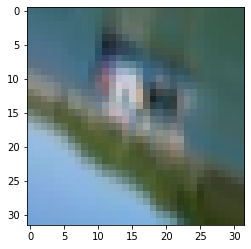

In [18]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
x,y = next(d_cls.train_gen)
print(x.shape)
print(y.shape)
print(y[0])
print(classes)
plt.imshow(x[0])
plt.show()

## ニューラルネットワーク定義

- VGG16+FC1+SE
- 15層以前をfreeze(ただし、Batch Normalizationはfreeze解除)

In [19]:
# モデル定義
model, orig_model = define_model.get_fine_tuning_model(output_dir, img_rows, img_cols, channels, nb_classes
                                                       , choice_model, trainable
                                                       , fcs=[256]
                                                       , activation=activation
                                                      )
# compile the model
optim = define_model.get_optimizers(choice_optim=choice_optim, lr=lr, momentum=momentum, nesterov=True)#, decay=decay)
#lr_metric = my_metric.get_lr_metric(optim)
model.compile(loss='categorical_crossentropy'
              , optimizer=optim
              , metrics=['accuracy'])
              #, metrics=['accuracy', lr_metric])

# finetunning用にレイヤーの数と名前を表示
count= 0
for layer in model.layers:
    print(count, layer.name)
    count+=1
keras.utils.plot_model(model, to_file=os.path.join(output_dir, 'VGG16_FC1.svg'), show_shapes=True)

model.summary()

----- model_param -----
output_dir = D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py
img_rows img_cols channels = 32 32 3
num_classes = 10
choice_model trainable = OctConv_WideResNet 15
fcs = [256]
fcpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
n_multitask = 1
oct_conv_alpha, wrn_N, wrn_k = 0.25 4 10
Instructions for updating:
Colocations handled automatically by placer.
----- FC_layers -----
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
dence dropout is_add_batchnorm kernel_initializer l2_rate = 256 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True
0 input_1
1 average_pooling2d_1
2 oct_conv2d_1
3 batch_normalization_1
4 batch_normalization_2
5 activation_1
6 activation_2
7 oct_conv2d_2
8 batch_normalization_5
9 batch_normalization_6
10 activation_5
1

batch_normalization_7 (BatchNor (None, 32, 32, 120)  480         oct_conv2d_3[0][0]               
__________________________________________________________________________________________________
batch_normalization_3 (BatchNor (None, 32, 32, 120)  480         conv2d_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_8 (BatchNor (None, 16, 16, 40)   160         oct_conv2d_3[0][1]               
__________________________________________________________________________________________________
batch_normalization_4 (BatchNor (None, 16, 16, 40)   160         conv2d_2[0][0]                   
__________________________________________________________________________________________________
activation_7 (Activation)       (None, 32, 32, 120)  0           batch_normalization_7[0][0]      
__________________________________________________________________________________________________
activation

__________________________________________________________________________________________________
batch_normalization_18 (BatchNo (None, 16, 16, 40)   160         oct_conv2d_8[0][1]               
__________________________________________________________________________________________________
activation_17 (Activation)      (None, 32, 32, 120)  0           batch_normalization_17[0][0]     
__________________________________________________________________________________________________
activation_18 (Activation)      (None, 16, 16, 40)   0           batch_normalization_18[0][0]     
__________________________________________________________________________________________________
oct_conv2d_9 (OctConv2D)        [(None, 32, 32, 120) 230400      activation_17[0][0]              
                                                                 activation_18[0][0]              
__________________________________________________________________________________________________
batch_norm

batch_normalization_29 (BatchNo (None, 16, 16, 240)  960         oct_conv2d_13[0][0]              
__________________________________________________________________________________________________
batch_normalization_30 (BatchNo (None, 8, 8, 80)     320         oct_conv2d_13[0][1]              
__________________________________________________________________________________________________
activation_29 (Activation)      (None, 16, 16, 240)  0           batch_normalization_29[0][0]     
__________________________________________________________________________________________________
activation_30 (Activation)      (None, 8, 8, 80)     0           batch_normalization_30[0][0]     
__________________________________________________________________________________________________
add_11 (Add)                    (None, 16, 16, 240)  0           activation_29[0][0]              
                                                                 add_9[0][0]                      
__________

__________________________________________________________________________________________________
activation_42 (Activation)      (None, 4, 4, 160)    0           batch_normalization_42[0][0]     
__________________________________________________________________________________________________
oct_conv2d_19 (OctConv2D)       [(None, 8, 8, 480),  3686400     activation_41[0][0]              
                                                                 activation_42[0][0]              
__________________________________________________________________________________________________
conv2d_5 (Conv2D)               (None, 8, 8, 480)    115680      average_pooling2d_4[0][0]        
__________________________________________________________________________________________________
conv2d_6 (Conv2D)               (None, 4, 4, 160)    12960       average_pooling2d_5[0][0]        
__________________________________________________________________________________________________
batch_norm

add_21 (Add)                    (None, 8, 8, 480)    0           activation_51[0][0]              
                                                                 add_19[0][0]                     
__________________________________________________________________________________________________
add_22 (Add)                    (None, 4, 4, 160)    0           activation_52[0][0]              
                                                                 add_20[0][0]                     
__________________________________________________________________________________________________
oct_conv2d_24 (OctConv2D)       [(None, 8, 8, 480),  3686400     add_21[0][0]                     
                                                                 add_22[0][0]                     
__________________________________________________________________________________________________
batch_normalization_54 (BatchNo (None, 4, 4, 160)    640         oct_conv2d_24[0][1]              
__________

## callback

In [20]:
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # 学習率をエポック増やすごとにコサインカーブで上げ下げする. epochsはコサインカーブのほぼ半周期になるエポック数
    cb.append(my_callback.cosine_annealing(epochs=num_epoch))

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=early_stopping, verbose=1))
    
    return cb

## 学習実行

In [21]:
%%time
start_time = time.time()
history = model.fit_generator(
    d_cls.train_gen,
    steps_per_epoch = d_cls.train_steps_per_epoch(),# 1エポックあたりの学習(step)回数
    epochs = num_epoch,# エポック数
    validation_data = d_cls.valid_gen,# 検証ファイル生成
    validation_steps = d_cls.valid_steps_per_epoch(),# 検証するファイル数
    verbose = 2,# 1:ログをプログレスバーで標準出力 2:最低限の情報のみ出す
    callbacks = get_cb(output_dir, cosine_annealing_num_epoch=None)
    )
end_time = time.time()
print("Elapsed Time : {:.2f}sec".format(end_time - start_time))

Instructions for updating:
Use tf.cast instead.
Epoch 1/5
 - 229s - loss: 1.9897 - acc: 0.2771 - val_loss: 1.7332 - val_acc: 0.3781

Epoch 00001: val_loss improved from inf to 1.73323, saving model to D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\finetuning.h5
Epoch 2/5
 - 220s - loss: 1.7689 - acc: 0.3795 - val_loss: 2.0401 - val_acc: 0.3405

Epoch 00002: val_loss did not improve from 1.73323
Epoch 3/5
 - 220s - loss: 1.6675 - acc: 0.4189 - val_loss: 1.4612 - val_acc: 0.4978

Epoch 00003: val_loss improved from 1.73323 to 1.46121, saving model to D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\finetuning.h5
Epoch 4/5
 - 221s - loss: 1.5892 - acc: 0.4488 - val_loss: 1.4470 - val_acc: 0.5093

Epoch 00004: val_loss improved from 1.46121 to 1.44695, saving model to D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\finetuning.h5
Epoch 5/5
 - 221s - loss: 1.5630 - acc: 0.4645 - val_loss: 1.3952 - val_acc: 0.5221

Epoch 00005: val_loss improved fr

## 学習曲線

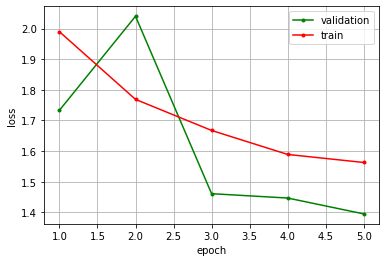

<Figure size 432x288 with 0 Axes>

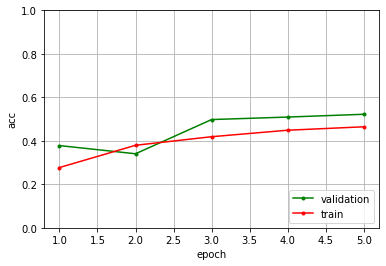

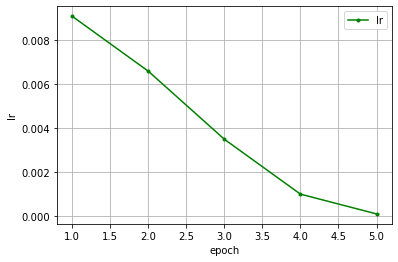

<Figure size 432x288 with 0 Axes>

In [23]:
import os
import matplotlib
#Jupyterでインライン表示するための宣言
%matplotlib inline
plot_log.plot_results(output_dir, os.path.join(output_dir, 'tsv_logger.tsv'))

## valid setのloss,acc評価

In [8]:
# Custom Functionを使ったmodelを別環境で使用するには、modelをロードする際に引数として、[custom_objects]を指定するがある
# https://qiita.com/tkinjo1/items/51f9e2d0d9c4659bde8a
#model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5'), custom_objects={'lr':lr_metric})

sys.path.append( r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\Git\OctConv-TFKeras' )
from oct_conv2d import OctConv2D
model = keras.models.load_model(os.path.join(output_dir, 'finetuning.h5')
                                , custom_objects={'OctConv2D':OctConv2D})

Instructions for updating:
Use tf.cast instead.


In [9]:
# val_batch_size, test_batch_size の枚数だけevaluate
scoreSeg = model.evaluate_generator(d_cls.valid_gen, val_batch_size)
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

val_loss =  1.3951799654960633
val_acc =  0.5220999953150749


In [10]:
# evaluate_generator はflow_from_directory でラベルクラスが親ディレクトリである場合しか使えない評価関数（lossとaccを出す）
# なので、基本train/validation setにしか使えない（test setは正解ラベルないケースが普通なので）

# evaluate_generator はgenerator だけ引数に渡したら全件予測してくれるみたい
# ただし、batch size ごとに予測するから総数/batch_size が割り切れる数になっていないと、あまりの分が2回predictされてしまう
# 安全な方法はbatch_size=1 にしたgenerator で実行（複数一気にpredictしないから時間かかる）
# https://medium.com/@vijayabhaskar96/tutorial-image-classification-with-keras-flow-from-directory-and-generators-95f75ebe5720
scoreSeg = model.evaluate_generator(d_cls.valid_gen)
print("val_loss = ",scoreSeg[0])
print("val_acc = ",scoreSeg[1])

ValueError: `steps=None` is only valid for a generator based on the `keras.utils.Sequence` class. Please specify `steps` or use the `keras.utils.Sequence` class.

## predict+混同行列

In [12]:
load_model = model

In [13]:
# generatorで全件予測
pred_df = base_predict.pred_classes_generator(load_model, d_cls.valid_gen, classes_list=class_name)
pred_df.to_csv(os.path.join(output_dir, 'pred.tsv'), sep='\t')
pred_df.head()

,Filename,PredictionLabel,PredictionScore
0,3\none,5,0.396
1,8\none,1,0.484
2,8\none,8,0.502
3,0\none,0,0.401
4,6\none,6,0.973


y_pred_list_str: ['5' '1' '8' ... '5' '1' '7']
y_true_label_np: ['3' '8' '8' ... '5' '1' '7']
------------------------------------
out_dir: D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py
              precision    recall  f1-score   support

           0       0.64      0.51      0.56      1000
           1       0.51      0.73      0.60      1000
           2       0.55      0.28      0.37      1000
           3       0.40      0.33      0.36      1000
           4       0.55      0.34      0.42      1000
           5       0.48      0.37      0.42      1000
           6       0.47      0.78      0.59      1000
           7       0.51      0.63      0.56      1000
           8       0.64      0.65      0.65      1000
           9       0.52      0.61      0.56      1000

   micro avg       0.52      0.52      0.52     10000
   macro avg       0.53      0.52      0.51     10000
weighted avg       0.53      0.52      0.51     10000

Confusion matrix, without normalizatio

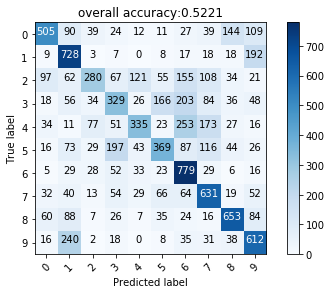

<Figure size 432x288 with 0 Axes>

In [14]:
# 予測結果のデータフレームから混同行列作成
base_predict.conf_matrix_from_pred_classes_generator(pred_df, classes, output_dir)

## 1件ずつ予測+GradCam

(32, 32, 3)
predict_score: [[0.03 0.02 0.02 0.31 0.02 0.4  0.03 0.07 0.05 0.06]]
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
max_pred_label:  5
pred_id: 5 0.3959696
(1, 32, 32, 3)


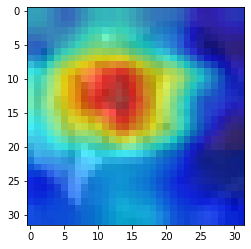

y_true_label : 3
D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\gradcam\FN\3_pred_5.jpg


In [17]:
from keras.preprocessing import image

# 画像のid
id = 0

# 前処理済み入力画像データ
X = d_cls.X_valid[id]
x = X*255.0
print(x.shape)

# grad_cam掛けるクラスid取得
pred_id, score = base_predict.pred_from_1X(load_model, X, classes)
print('pred_id:', pred_id, score)

# 4次元テンソルへ変換
X = np.expand_dims(X, axis=0)
print(X.shape)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_55', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = d_cls.y_valid[id].argmax() # 正解ラベルであるファイルの直上のフォルダ名のみを取得
print('y_true_label :', y_true_label)
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, str(y_true_label)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

### 他の画像でもGradCam実行

(32, 32, 3)
predict_score: [[0.01 0.49 0.01 0.11 0.   0.2  0.01 0.04 0.01 0.11]]
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
max_pred_label:  1
pred_id: 1 0.48867792
(1, 32, 32, 3)


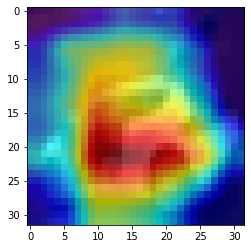

y_true_label : 1
D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\gradcam\TP\1_pred_1.jpg


In [19]:
from keras.preprocessing import image

# 画像のid
id = 6

# 前処理済み入力画像データ
X = d_cls.X_valid[id]
x = X*255.0
print(x.shape)

# grad_cam掛けるクラスid取得
pred_id, score = base_predict.pred_from_1X(load_model, X, classes)
print('pred_id:', pred_id, score)

# 4次元テンソルへ変換
X = np.expand_dims(X, axis=0)
print(X.shape)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_55', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = d_cls.y_valid[id].argmax() # 正解ラベルであるファイルの直上のフォルダ名のみを取得
print('y_true_label :', y_true_label)
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, str(y_true_label)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

(32, 32, 3)
predict_score: [[0.04 0.11 0.   0.   0.   0.   0.   0.   0.22 0.63]]
classes: ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9']
max_pred_label:  9
pred_id: 9 0.6269356
(1, 32, 32, 3)


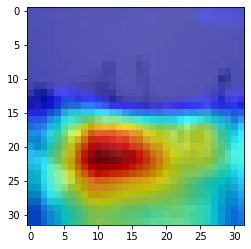

y_true_label : 8
D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\gradcam\FN\8_pred_9.jpg


In [20]:
from keras.preprocessing import image

# 画像のid
id = 18

# 前処理済み入力画像データ
X = d_cls.X_valid[id]
x = X*255.0
print(x.shape)

# grad_cam掛けるクラスid取得
pred_id, score = base_predict.pred_from_1X(load_model, X, classes)
print('pred_id:', pred_id, score)

# 4次元テンソルへ変換
X = np.expand_dims(X, axis=0)
print(X.shape)

# grad_cam
class_output = load_model.output[:, pred_id]
jetcam = grad_cam.grad_cam(load_model, X, x, 'activation_55', img_rows, img_cols, class_output)

# Grad-cam画像保存+表示
grad_cam_img = image.array_to_img(jetcam)
plt.imshow(grad_cam_img)
plt.show()

# TP/FN/FP/TN/NAN を判定し、判定結果を出力パスに含める
y_true_label = d_cls.y_valid[id].argmax() # 正解ラベルであるファイルの直上のフォルダ名のみを取得
print('y_true_label :', y_true_label)
judge = grad_cam.judge_evaluate(pred_id, y_true_label, positive=y_true_label, negative=pred_id)
judge_out_grad_cam_dir = os.path.join(output_dir, 'gradcam', judge)
out_jpg = os.path.join(judge_out_grad_cam_dir, str(y_true_label)+'_pred_'+classes[pred_id]+'.jpg')
print(out_jpg)

# ファイル出力
#os.makedirs(judge_out_grad_cam_dir, exist_ok=True)
#grad_cam_img.save(out_jpg, 'JPEG', quality=100, optimize=True)

# --------------------------------------------------------------------------------------------

# Optunaで学習実行

In [3]:
# モジュールimport
import os, sys
sys.path.append(r'C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py')
from dataset import plot_log, prepare_data, util, plot_12task_log, util
from transformer import get_train_valid_test, my_generator
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam, ensemble_predict, base_predict
from tuning import optuna_train_base, optuna_train_Tox21, optuna_util

sys.path.append(r'C:\Users\shingo\Git\keras-squeeze-excite-network')
import se_inception_v3, se_densenet, se_inception_resnet_v2, se_resnet, se_resnext, se

import keras
import optuna
import numpy as np
import shutil
%matplotlib inline

import keras
from keras.datasets import cifar10
# The data, shuffled and split between train and test sets:
(x_train, y_train), (x_test, y_test) = cifar10.load_data()
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
print(y_train.shape[0], 'train samples')
print(y_test.shape[0], 'test samples')
print(y_test[0], 'label -> ex: 3 ')
# Convert class vectors to binary class matrices.
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)
print(y_test[0])


# 画像管理クラス
d_cls=get_train_valid_test.LabeledDataset([32, 32, 3]
                                          , 100
                                          , valid_batch_size=100
                                          , test_batch_size=100
                                          , train_samples = 50000
                                          , valid_samples = 10000 
                                         )
d_cls.X_train = x_train/255.0
d_cls.y_train = y_train
d_cls.X_valid = x_test/255.0
d_cls.y_valid = y_test

# 基本コールバック
def get_cb(output_dir, cosine_annealing_num_epoch=None):
    cb = []

    # ログを保存するカスタムコールバック
    cb.append(my_callback.tsv_logger(os.path.join(output_dir, 'tsv_logger.tsv')))
    
    # epochごとに学習曲線保存する自作callback
    cb.append(my_callback.learning_curve_plot(os.path.join(output_dir, 'learning_curve.png')))
    
    # 各エポックでval_lossが最小となるモデル保存
    cb.append(keras.callbacks.ModelCheckpoint(filepath=os.path.join(output_dir, 'finetuning.h5'), monitor='val_loss', save_best_only=True, verbose=1))

    # 過学習の抑制 <early_stopping_pati>step続けてval_loss減らなかったら打ち切る
    cb.append(keras.callbacks.EarlyStopping(monitor='val_loss', patience=10, verbose=1))
    
    return cb

x_train shape: (50000, 32, 32, 3)
50000 train samples
10000 test samples
y_train shape: (50000, 1)
50000 train samples
10000 test samples
[3] label -> ex: 3 
[0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
train_steps_per_epoch : 500
valid_steps_per_epoch : 100


### 目的関数の定義
#### チューニング可能パラメータ
- モデル（ニューラルネットワーク）
    - Imagenetの学習済みモデル
    - fine-tuning
    - 全結合0-5層（重みの初期値はhe_normal(He の正規分布)で固定）
        - ユニット数 (同じ値か層ごとに減らす)
        - dropout_rate (全層同じ値になる)
        - Batch_Normalization (全層同じ値になる)
        - l2正則化(weight decay) (全層同じ値になる)
- オプティマイザ
- 学習率
    - 学習率変更なし
    - cosine_annealing(factor=0.01, epochs=None)
    - LearningRateScheduler(lr* 1/4 を3回する)
- データ水増し( keras.preprocessing.image.ImageDataGenerator )
    - 画像の剪断(shear)
    - 拡大縮小(zoom)
    - 回転(rotation)
    - 上下反転(vertical_flip)
    - 左右反転(horizontal_flip)
    - 画像の一部矩形領域を隠す（random_erasing)
    - 画像混ぜる(mix_up)

In [4]:
# 出力ディレクトリ
output_dir = r'D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\optuna'
os.makedirs(output_dir, exist_ok=True)

## best_parameter をval_loss でとる
return_val_loss=True

### チューニング可能パラメータ引数 ###
## model param
choice_model = ['OctConv_WideResNet']#['VGG16']# 学習済みモデル
trainable = [15, 'all'] # 重みは全層学習させる（重みunfreeze開始レイヤーを番号で指定できる）
FCnum = [0,1,4] # FC層の数
Dence = [1024, 512, 256, 128] # FC層のユニット数
Dropout = [0.0, 0.5] # FC層のDropout
addBatchNorm = [None] # FC層のBatchNorm
l2 = [0.0, 1e-4] # FC層のl2
choice_optim = ['sgd', 'adam', 'nadam'] # optimizer
lr = [0.0, 1e-5, 1e-4, 1e-3, 1e-2, 1e-1] # （初期）学習率
callback_lr = [None, 'cosine_annealing'] # 学習率変更するcallback
callback_save_model=True # モデル保存するcallback つけるか. False なら保存しない

if callback_save_model == True:
    model_dir = os.path.join(output_dir, 'model_weight_optuna')

## ImageDataGenerator param
rescale=1.0 # 画像の前処理
horizontal_flip=[True] # 画像の左右反転
vertical_flip=[True, False] # 画像の上下反転
# 画像の回転の下限角、回転の上限角、回転角の刻み幅
rotation_range_min=0 
rotation_range_max=180
rotation_unit=10 # 0.0 にしたら rotation_range_max で固定
# 画像の縮小の最少-最大倍率、拡大の最少-最大倍率、縮小拡大倍率の刻み幅
zoom_range_low_min=0.5
zoom_range_low_max=1.0
zoom_range_high_min=1.0
zoom_range_high_max=1.5
zoom_range_unit=1.0 # 0.0 にしたら zoom_range_low_min, zoom_range_high_max で固定
# 画像のせん断の最少倍率、せん断の最大倍率、せん断倍率の刻み幅
shear_range_min=0.0
shear_range_max=0.5
shear_range_unit=0.1 # 0.0 にしたら shear_range_max で固定
random_eraser_flg= [True, False] # Random Erasing 含めるか
pixel_min=np.min(d_cls.X_train) # Random Erasing で使う画素数の最小値
pixel_max=np.max(d_cls.X_train) # Random Erasing で使う画像数の最大値（1/255で割ってるはずだから基本1.0）
# mixup 含めるか
use_mixup=[True, False]

# パラメータを引数に持たせてoptunaの目的関数を定義
objective = optuna_train_Tox21.Objective(out_dir=output_dir
                                        , d_cls=d_cls
                                        , shape=[32, 32, 3]
                                        , num_classes=10
                                        , epochs=1
                                        , gpu_count=1
                                        , loss='categorical_crossentropy'
                                        , metrics=['acc']
                                        , verbose=2
                                        , activation='softmax'
                                        , pred_kernel_initializer='zeros'
                                        , pred_l2_rate=0.0001
                                        , FCpool='GlobalAveragePooling2D'
                                        , return_val_loss=return_val_loss
                                        , callbacks=get_cb(output_dir, cosine_annealing_num_epoch=None)
                                        , callback_save_model=callback_save_model
                                        , choice_model=choice_model
                                        , trainable=trainable
                                        , FCnum=FCnum
                                        , Dence=Dence
                                        , Dropout=Dropout
                                        , addBatchNorm=addBatchNorm
                                        , l2=l2
                                        , choice_optim=choice_optim
                                        , lr=lr
                                        , callback_lr=callback_lr
                                        , horizontal_flip=horizontal_flip
                                        , vertical_flip=vertical_flip
                                        , rotation_range_min=rotation_range_min
                                        , rotation_range_max=rotation_range_max
                                        , rotation_unit=rotation_unit
                                        , zoom_range_low_min=zoom_range_low_min
                                        , zoom_range_low_max=zoom_range_low_max
                                        , zoom_range_high_min=zoom_range_high_min
                                        , zoom_range_high_max=zoom_range_high_max
                                        , zoom_range_unit=zoom_range_unit
                                        , shear_range_min=shear_range_min
                                        , shear_range_max=shear_range_max
                                        , shear_range_unit=shear_range_unit
                                        , random_eraser_flg=random_eraser_flg
                                        , pixel_min=pixel_min
                                        , pixel_max=pixel_max
                                        , use_mixup=use_mixup
                                        , branch_Tox21_12task=[False]
                                       )

### 最適化の実行

In [5]:
%%time
# sqlite 使って履歴ファイル作る
sqllite_path = output_dir+'/example.db'
if os.path.exists(sqllite_path) == True:
    os.remove(sqllite_path) # sqllite_pathすでにあれば一旦削除
study = optuna.create_study(study_name='example-study', storage='sqlite:///'+sqllite_path)

study.optimize(objective, n_trials=2)

[I 2019-07-06 22:56:41,077] A new study created with name: example-study
[W 2019-07-06 22:56:43,504] Setting status of trial#0 as TrialState.FAIL because of the following error: ValueError('tuple.index(x): x not in tuple',)
Traceback (most recent call last):
  File "C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\tuning/../Git/optuna\optuna\study.py", line 468, in _run_trial
    result = func(trial)
  File "C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\tuning\optuna_train_Tox21.py", line 401, in __call__
    model, orig_model = self._optuna_model(trial, branch_Tox21_12task)
  File "C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\tuning\optuna_train_Tox21.py", line 192, in _optuna_model
    trainable = trial.suggest_categorical('trainable', self.trainable)
  File "C:\Users\shingo\jupyter_notebook\tfgpu_py36_work\02_keras_py\tuning/../Git/optuna\optuna\trial.py", line 337, in suggest_categorical
    return self._suggest(name, distributions.Categor

----- model_param -----
output_dir = D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_from_02_keras_py\optuna
img_rows img_cols channels = 32 32 3
num_classes = 10
choice_model trainable = OctConv_WideResNet all
FCnum = 4
FCpool = GlobalAveragePooling2D
pred_kernel_initializer pred_l2_rate = zeros 0.0001
activation = softmax
gpu_count = 1
skip_bn = True
oct_conv_alpha, wrn_N, wrn_k = 0.25 4 10
16
160
160
160
160
160
160
160
160
320
320
320
320
320
320
320
320
640
640
640
640
640
640
640
----- FC_layer -----
dence dropout addBatchNorm kernel_initializer l2_rate = 256 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 192 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 144 0.5 None he_normal 0.0001
dence dropout addBatchNorm kernel_initializer l2_rate = 108 0.5 None he_normal 0.0001
---- choice_optim = sgd ----
sgd_lr sgd_momentum sgd_decay sgd_nesterov = 0.01 0.9 0.0 True


[W 2019-07-06 22:56:57,908] The range of parameter `zoom_range_low` is not divisible by `q`, and is replaced by [0.5, 0.5].
[W 2019-07-06 22:56:58,083] The range of parameter `zoom_range_high` is not divisible by `q`, and is replaced by [1.0, 1.0].
[W 2019-07-06 22:56:58,240] The range of parameter `shear_range` is not divisible by `q`, and is replaced by [0.0, 0.4].


----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': False, 'rotation_range': 90.0, 'zoom_range': [0.5, 1.0], 'shear_range': 0.0, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x00000261DCD8F840>}


[W 2019-07-06 22:56:59,401] The use of `Trial.trial_id` is deprecated. Please use `Trial.number` instead.
[W 2019-07-06 22:56:59,413] The use of `Trial.trial_id` is deprecated. Please use `Trial.number` instead.


Epoch 1/1


KeyboardInterrupt: 

### 結果の確認

In [33]:
# 試行結果データフレームで出力
study = optuna.Study(study_name='example-study', storage='sqlite:///'+sqllite_path)
df = study.trials_dataframe()
df.to_csv(os.path.join(output_dir, 'optuna_lgb.tsv'), sep='\t')
df

trial_id                state     value             datetime_start  \
                                                                       
0        1  TrialState.COMPLETE  2.885443 2019-01-22 00:08:01.613087   
1        2  TrialState.COMPLETE  0.325050 2019-01-22 00:08:44.686856   

           datetime_complete  params                                  \
                             Dence_1 Dence_2 Dence_3 Dence_4 Dropout   
0 2019-01-22 00:08:44.498513     256   128.0    64.0    64.0     0.5   
1 2019-01-22 00:09:28.035780    1024   768.0   384.0   192.0     0.5   

          ...         user_attrs                       \
          ...               loss  metrics num_classes   
0         ...           2.876772  ['acc']          10   
1         ...           0.325071  ['acc']          10   

                                                                              \
                                             out_dir pred_kernel_initializer   
0  D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_...                   zeros   
1  D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_...                   zeros   

                                              intermediate_values  
  pred_l2_rate        shape val_acc  val_loss                   0  
0       0.0001  [32, 32, 3]  0.9000  2.885443            2.885443  
1       0.0001  [32, 32, 3]  0.8097  0.325050            0.325050  

[2 rows x 42 columns]

In [34]:
# study.best_params ファイル出力
f = open(os.path.join(output_dir, 'best_params.txt'), 'w') # 書き込みモードで開く
for key,value in sorted(study.best_params.items()):
    f.write('{0}\t{1}\n'.format(key, value))
f.close() # ファイル閉じる
study.best_params

{'Dence_1': 1024,
 'Dence_2': 768.0,
 'Dence_3': 384.0,
 'Dence_4': 192.0,
 'Dropout': 0.5,
 'FCnum': 4,
 'addBatchNorm': None,
 'branch_Tox21_12task': False,
 'callback_lr': None,
 'choice_model': 'VGG16',
 'choice_optim': 'sgd',
 'horizontal_flip': True,
 'l2': 0.0,
 'lr': 0.0001,
 'random_eraser_flg': True,
 'rotation_range': 160.0,
 'shear_range': 0.4,
 'trainable': 15,
 'use_mixup': False,
 'vertical_flip': True,
 'zoom_range_high': 1.0,
 'zoom_range_low': 1.0}

In [35]:
study.best_trial 

FrozenTrial(trial_id=2, state=<TrialState.COMPLETE: 1>, value=0.3250504344701767, datetime_start=datetime.datetime(2019, 1, 22, 0, 8, 44, 686856), datetime_complete=datetime.datetime(2019, 1, 22, 0, 9, 28, 35780), params={'Dence_1': 1024, 'Dence_2': 768.0, 'Dence_3': 384.0, 'Dence_4': 192.0, 'Dropout': 0.5, 'FCnum': 4, 'addBatchNorm': None, 'branch_Tox21_12task': False, 'callback_lr': None, 'choice_model': 'VGG16', 'choice_optim': 'sgd', 'horizontal_flip': True, 'l2': 0.0, 'lr': 0.0001, 'random_eraser_flg': True, 'rotation_range': 160.0, 'shear_range': 0.4, 'trainable': 15, 'use_mixup': False, 'vertical_flip': True, 'zoom_range_high': 1.0, 'zoom_range_low': 1.0}, user_attrs={'FCpool': 'GlobalAveragePooling2D', 'acc': 0.8961800001561642, 'activation': 'softmax', 'callbacks': '[<model.my_callback.tsv_logger.<locals>._TSVLogger object at 0x000002091A5C5278>, <model.my_callback.learning_curve_plot.<locals>._LearningCurvePlotter object at 0x000002091A5C5208>, <keras.callbacks.ModelCheckpoin

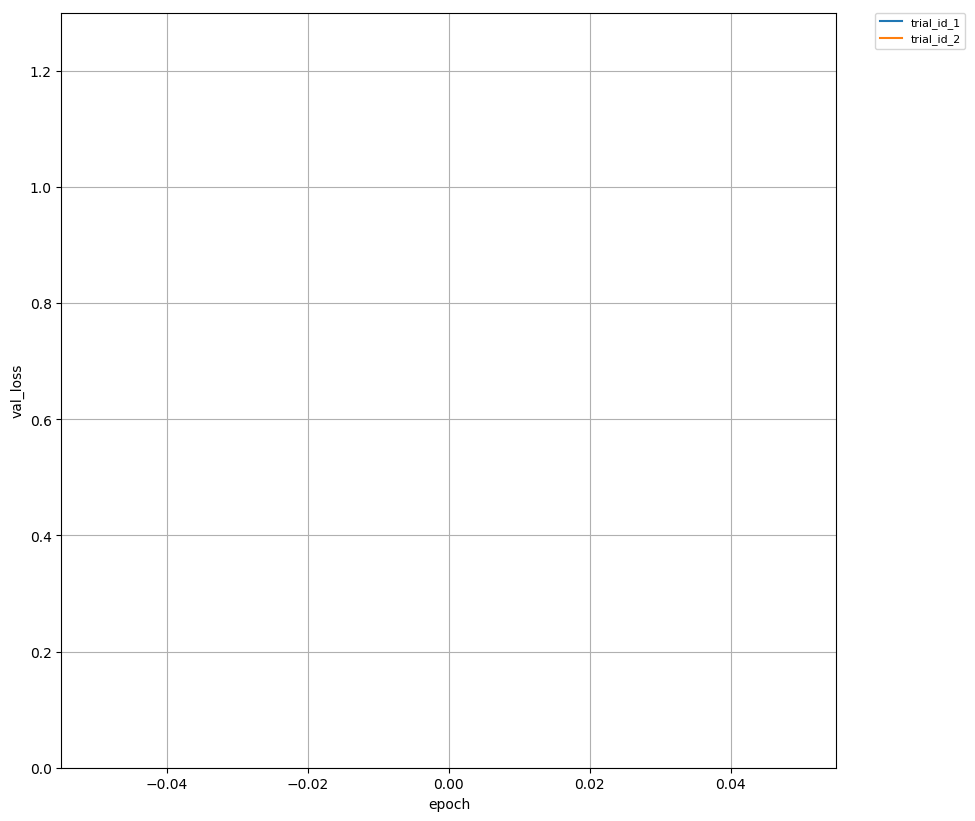

,Unnamed: 0,trial_id,state,value,datetime_start,datetime_complete,params,params.1,params.2,params.3,...,user_attrs.5,user_attrs.6,user_attrs.7,user_attrs.8,user_attrs.9,user_attrs.10,user_attrs.11,user_attrs.12,user_attrs.13,intermediate_values
0,NaN,NaN,NaN,NaN,NaN,NaN,Dence_1,Dence_2,Dence_3,Dence_4,...,loss,metrics,num_classes,out_dir,pred_kernel_initializer,pred_l2_rate,shape,val_acc,val_loss,0.000000
1,0.0,1.0,TrialState.COMPLETE,2.885443,2019-01-22 00:08:01.613087,2019-01-22 00:08:44.498513,256,128.0,64.0,64.0,...,2.876772137582302,['acc'],10,D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_...,zeros,0.0001,"[32, 32, 3]",0.8999999997578562,2.8854430747032165,2.885443
2,1.0,2.0,TrialState.COMPLETE,0.325050,2019-01-22 00:08:44.686856,2019-01-22 00:09:28.035780,1024,768.0,384.0,192.0,...,0.3250714740753174,['acc'],10,D:\work\kaggle_data\CIFAR10\results\VGG16+FC1_...,zeros,0.0001,"[32, 32, 3]",0.8096999999880791,0.3250504344701767,0.325050


<Figure size 432x288 with 0 Axes>

In [11]:
# trial結果ロード
import pandas as pd
result_df = pd.read_table(os.path.join(output_dir, 'optuna_lgb.tsv'))
# optunaのtrial結果plot
optuna_util.trial_plot(output_dir, result_df, epochs=1, val_name="val_loss", trial_id=None)# , trial_id=None # , trial_id=2 # , trial_id=[2,45,46,47,48,49]
result_df
